In [26]:
import pandas as pd
import seaborn as sns
import numpy as np
import graphviz
import matplotlib.pyplot as plt
import matplotlib as mlp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn import mixture
import itertools
from scipy import linalg

from sklearn.decomposition import FastICA, PCA

-1    4849
 1    1001
Name: cleave, dtype: int64

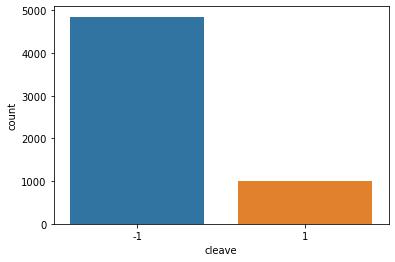

In [2]:
# Dataset source:
#http://archive.ics.uci.edu/ml/datasets/HIV-1+protease+cleavage#
# combined all datasets, removing duplicates

# Read in data
data = pd.read_csv('../data/HIV_DataSet.csv', sep=',')

sns.countplot(data['cleave']) # plot number of things with each value
# number of negative cleave values versus positive.
data['cleave'].value_counts(sort=True)

In [3]:
# Create training, testing, and validation sets

X = data.drop('cleave', axis=1) # last value is the cleavage
y = data['cleave']

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2) # 80/20 default

# scale so it converges
scaling = MinMaxScaler()
x_train = scaling.fit_transform(x_train)
x_test = scaling.transform(x_test)

enc = OneHotEncoder(categories='auto')
y_train = enc.fit_transform(y_train.values.reshape(-1, 1)).todense()
y_test = enc.transform(y_test.values.reshape(-1, 1)).todense()

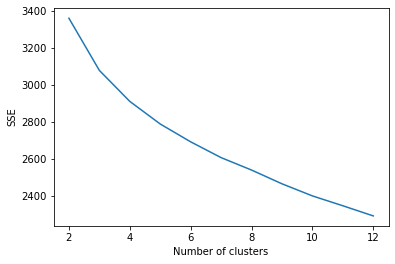

k=6
[[0.40851313 0.27579522 0.63121993 0.78114454 0.42069362 0.32878581
  0.38565377 0.34508509 0.48639334]
 [0.52599101 0.3461703  0.78105834 0.21095421 0.48844673 0.47532449
  0.44929397 0.43831123 0.44508629]
 [0.50436669 0.2640437  0.2411604  0.39602864 0.40695357 0.52218203
  0.76430206 0.48852144 0.42053591]
 [0.8794843  0.79516358 0.43817704 0.46859613 0.44961155 0.45130758
  0.45081519 0.44446876 0.44009191]
 [0.54344617 0.30727763 0.21322173 0.30550433 0.37061995 0.41608739
  0.19229678 0.43332388 0.46992481]
 [0.15457236 0.69251728 0.4213849  0.60360181 0.63516746 0.59808612
  0.49129452 0.60446571 0.60486443]]
BEST GMM
GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=6, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)


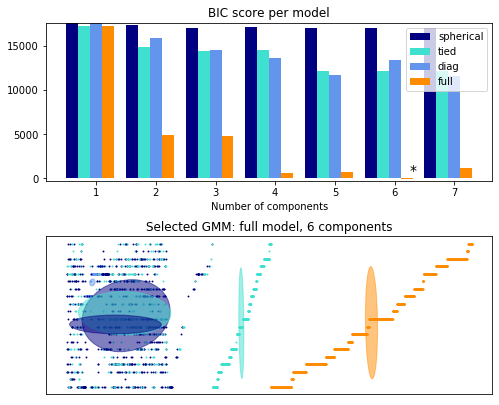

In [47]:
centers = kmeans()
# k=6 appears to be the elbow.
print('k=' + str(6))
print(centers[6])
em()


In [6]:
# K-Means
# used https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
def kmeans():
    # How to choose the # of clusters
    clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    scores = {'sil': [], 'var': [], 'n_clusters': []}
    centers = {}

    sse = {}
    lowest_bic = np.infty
    bic = []
    for c in clusters:
        kmeans = KMeans(n_clusters=c, random_state=42)
        kmeans.fit(x_train)
        # these are the labels
        y_kmeans_pred=kmeans.predict(x_test)


        center = kmeans.cluster_centers_
        centers[c] = center
        #plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
        #plt.scatter(center[:, 0], center[:, 1], c='black', s=200, alpha=0.5)
        sse[c] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    

    # elbow
    #https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of clusters")
    plt.ylabel("SSE")
    plt.savefig('../images/' + 'elbow_KM_hiv.png')
    plt.show()
    
    # returns list of importance of each feat for each cluster
    return centers


In [7]:
# Stolen from 
#https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py

def em():
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 8)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type, random_state=42)
            gmm.fit(x_train)
            bic.append(gmm.bic(x_train))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    bic = np.array(bic)
    color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                                  'darkorange'])
    clf = best_gmm
    print('BEST GMM')
    print(clf)
    bars = []

    # Plot the BIC scores
    plt.figure(figsize=(8, 6))
    spl = plt.subplot(2, 1, 1)
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + .2 * (i - 2)
        bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                      (i + 1) * len(n_components_range)],
                            width=.2, color=color))
    plt.xticks(n_components_range)
    plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title('BIC score per model')
    xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
        .2 * np.floor(bic.argmin() / len(n_components_range))
    plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
    spl.set_xlabel('Number of components')
    spl.legend([b[0] for b in bars], cv_types)

    # Plot the winner
    splot = plt.subplot(2, 1, 2)
    y_em_pred = clf.predict(x_train)
    for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                               color_iter)):
        v, w = linalg.eigh(cov)
        if not np.any(y_em_pred == i):
            continue
        plt.scatter(x_train[y_em_pred == i, 0], x_train[y_em_pred == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan2(w[0][1], w[0][0])
        angle = 180. * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mlp.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(.5)
        splot.add_artist(ell)

    plt.xticks(())
    plt.yticks(())
    plt.title('Selected GMM: ' + clf.covariance_type + ' model, ' + str(clf.n_components) +' components')
    plt.subplots_adjust(hspace=.35, bottom=.02)
    plt.savefig('../images/' + 'best_EM_hiv.png')
    plt.show()
    

variance
[0.14968103 0.28067925 0.39920341 0.51187173 0.62203027 0.72900919
 0.82986867 0.92539303 1.        ]
LOSS
0.006613932504832572
LEARNED COMPONENTS
[[-0.63245099 -0.15926067  0.08311805  0.40088089  0.3957534   0.27574753
   0.18792144  0.24318432  0.28269623]
 [-0.31152364 -0.77196084  0.03688441 -0.01845117 -0.20641588 -0.35568372
  -0.18887178 -0.30258377 -0.09476636]
 [-0.06297209 -0.2816393  -0.23987631 -0.45916756 -0.24174125  0.20752491
   0.61514017  0.37284102 -0.17153733]
 [-0.08555949 -0.00315719 -0.80661876 -0.07852063  0.04127098 -0.08714498
  -0.44009109  0.27758356  0.23630478]
 [ 0.03288595  0.10845504 -0.162978    0.68829233 -0.40815759 -0.36271566
   0.23419979  0.2651677  -0.25204987]
 [-0.00632766 -0.00124452  0.37068098 -0.24750395  0.28983914 -0.53751373
  -0.15367158  0.62929316 -0.09350533]
 [-0.037224   -0.06347627  0.33049689  0.02864735 -0.58497365  0.43756537
  -0.44958697  0.36706644  0.11837408]
 [-0.01407931  0.11542151  0.101775   -0.11981751 -0.

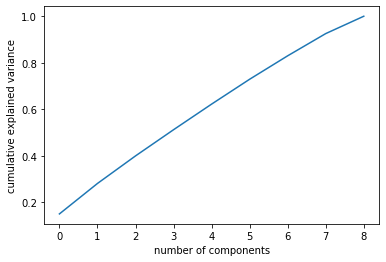

In [45]:
# PCA
#https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
# dummy with no best fit reduction
'''
pca = PCA(n_components=1)
pca.fit(x_train)
x_pca = pca.transform(x_train)
print("original shape:   ", x_train.shape)
print("transformed shape:", x_pca.shape)
# learned components
print(pca.components_)
# Explained variance
print(pca.explained_variance_)
'''


#To understand the effect of this dimensionality reduction,
#we can perform the inverse transform of this reduced data 
#and plot it along with the original data:

'''
X_new = pca.inverse_transform(x_pca)
plt.scatter(x_train[:, 0], x_train[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal')
'''

# choosing number of components
rand_state=42
pca = PCA(random_state=rand_state).fit(x_train)
x_pca = pca.transform(x_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.savefig('../images/' + 'PCA_components_hiv.png')

# so basically, to get 90% of the variance (info), I need to retain 8 components
print('variance')
print(np.cumsum(pca.explained_variance_ratio_))

# how well does it reconstruct data set?
pca_opt = PCA(n_components=8, random_state=rand_state).fit(x_train)
x_train_pca = pca_opt.transform(x_train)
X_projected = pca_opt.inverse_transform(x_train_pca)
loss = ((x_train - X_projected) ** 2).mean()
print("LOSS")
print(loss)
# learned components
print('LEARNED COMPONENTS')
print(pca.components_)
# Explained variance
print('Explained Variance')
print(pca.explained_variance_)

[0.3696841321332176, 0.4245192568898679, 0.5284122727887591, 0.5952667854321546, 0.6813955104852434, 0.7356383033999864, 1.0122606528517148, 1.1099031880822592, 1.2136987310951073]


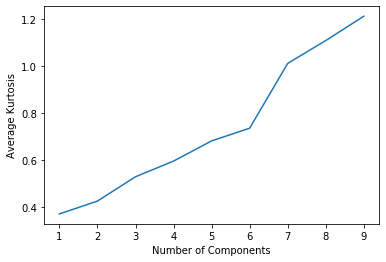

In [46]:
# ICA
# choosing number of components
comps = [1, 2, 3, 4, 5, 6, 7, 8, 9]
kurtosis = []
# based on description in https://piazza.com/class/k51r1vdohil5g3?cid=569
#Calculate the absolute value of kurtosis of each feature
#Take the mean of all these values, and use that as a score for the FastICA algorithm 
# with that number of components
# Pick the number of components that maximizes this score
for comp in comps:
    ica = FastICA(n_components=comp, random_state=rand_state).fit(x_train)
    x_train_ica = ica.transform(x_train)
    kurtosis.append(pd.DataFrame(x_train_ica).kurt().abs().mean())
print(kurtosis)
plt.xlabel('Number of Components')
plt.ylabel('Average Kurtosis')
plt.plot(comps, kurtosis)
plt.savefig('../images/' + 'ICA_kurtosis_hiv.png')
# so no component reduction here. needs all of them?


In [ ]:
# RCA

In [ ]:
# My Choice

In [ ]:
# PCA + KMeans
# PCA + EM

In [ ]:
# ICA + KMeans
# ICA + EM

In [ ]:
# RCA + KMeans
# RCA + EM

In [ ]:
# Choice + KMeans
# Choice + EM

In [ ]:
# For one of them, all of the dim + NNet (4)

In [ ]:
# For one of them EM and KMeans + NNet (2)